✅ 匹配图像数：444
📁 训练集：355 张，测试集：89 张
(505, 490, 3)


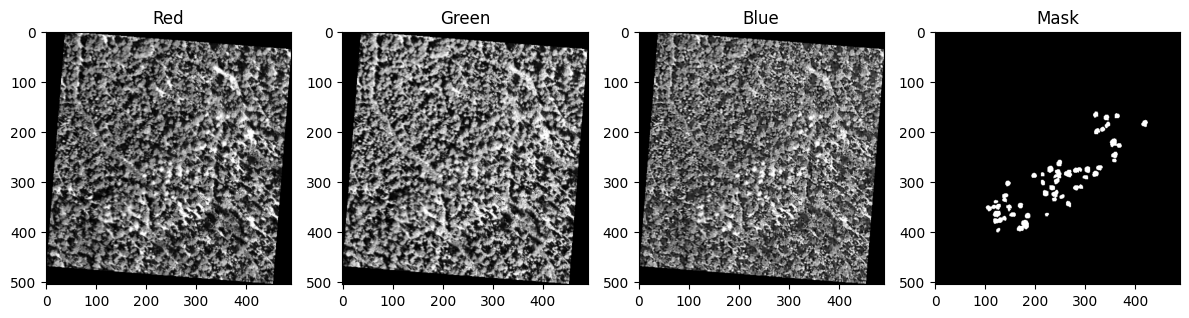

In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import shutil
import random

# === 配置路径 ===
rgb_dir = "USA_segmentation/RGB_images"
mask_dir = "USA_segmentation/masks"
train_img_dir = "data/train/images"
train_mask_dir = "data/train/masks"
test_img_dir = "data/test/images"
test_mask_dir = "data/test/masks"

# === 创建目标目录 ===
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)
os.makedirs(test_img_dir, exist_ok=True)
os.makedirs(test_mask_dir, exist_ok=True)

# === 获取所有 RGB 文件（去掉前缀 RGB_） ===
rgb_files = os.listdir(rgb_dir)
mask_files = os.listdir(mask_dir)

def normalize_name(filename):
    return filename.lower().replace("rgb_", "").replace("nrg_", "").replace("mask_", "")

# 构建匹配对（RGB ↔ mask）
valid_pairs = []
for rgb_file in rgb_files:
    norm_rgb = normalize_name(rgb_file)
    for mask_file in mask_files:
        norm_mask = normalize_name(mask_file)
        if norm_rgb == norm_mask:
            valid_pairs.append((rgb_file, mask_file))
            break

print(f"✅ 匹配图像数：{len(valid_pairs)}")

# === 打乱并划分 ===
random.seed(42)
random.shuffle(valid_pairs)
split = int(0.8 * len(valid_pairs))
train_pairs = valid_pairs[:split]
test_pairs = valid_pairs[split:]

# === 拷贝函数 ===
def copy_pairs(pairs, img_src, mask_src, img_dst, mask_dst):
    for rgb_file, mask_file in pairs:
        shutil.copy(os.path.join(img_src, rgb_file), os.path.join(img_dst, rgb_file))
        shutil.copy(os.path.join(mask_src, mask_file), os.path.join(mask_dst, mask_file))

copy_pairs(train_pairs, rgb_dir, mask_dir, train_img_dir, train_mask_dir)
copy_pairs(test_pairs, rgb_dir, mask_dir, test_img_dir, test_mask_dir)

print(f"📁 训练集：{len(train_pairs)} 张，测试集：{len(test_pairs)} 张")

# === 可视化一个样本 ===
sample_rgb, sample_mask = train_pairs[0]
img = cv2.imread(os.path.join(train_img_dir, sample_rgb))
mask = cv2.imread(os.path.join(train_mask_dir, sample_mask), cv2.IMREAD_GRAYSCALE)
b, g, r = cv2.split(img)
print(img.shape)

plt.figure(figsize=(12,4))
plt.subplot(1,4,1); plt.imshow(r, cmap='gray'); plt.title("Red")
plt.subplot(1,4,2); plt.imshow(g, cmap='gray'); plt.title("Green")
plt.subplot(1,4,3); plt.imshow(b, cmap='gray'); plt.title("Blue")
plt.subplot(1,4,4); plt.imshow(mask, cmap='gray'); plt.title("Mask")
plt.tight_layout(); plt.show()


In [ ]:
# ==== 启动训练 ====
best_iou = 0
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss, total_iou = 0, 0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = model(imgs)
        loss = combined_loss(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        total_iou += compute_iou(preds, masks)

    avg_loss = total_loss / len(train_loader)
    avg_iou = total_iou / len(train_loader)

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | IoU: {avg_iou:.4f}")

    scheduler.step(avg_iou)
    if avg_iou > best_iou:
        best_iou = avg_iou
        patience_counter = 0
        torch.save(model.state_dict(), "best_unet_model.pth")
        print(f"✅ 保存新最佳模型 (IoU = {best_iou:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("🛑 Early stopping.")
            break
